In [1]:
# Importación de paquetes.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
%matplotlib inline

C:\Users\marco\AppData\Local\Temp\ipykernel_28832\1865039913.py:6: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
# Función para aplicar suavizado utilizando el filtro Savitzky-Golay en una región específica
def apply_savgol_smoothing(y, transition_index, window_length1, polyorder1, window_length2, polyorder2):
    y_smooth = np.copy(y)
    y_smooth[:transition_index+1] = ss.savgol_filter(y[:transition_index+1], window_length=window_length1, polyorder=polyorder1)
    y_smooth[transition_index:] = ss.savgol_filter(y[transition_index:], window_length=window_length2, polyorder=polyorder2)
    return y_smooth

In [3]:
# Función para aplicar suavizado con kernel gaussiano en una región específica
def apply_mix_smoothing(y, transition_index, window_length1, polyorder1, sigma2):
    y_smooth = np.copy(y)
    y_smooth[:transition_index+1] = ss.savgol_filter(y[:transition_index+1], window_length=window_length1, polyorder=polyorder1)
    y_smooth[transition_index:] = gaussian_filter1d(y[transition_index:], sigma=sigma2, order=0)
    return y_smooth

In [4]:
# Importación de datos TG de Mica-2 pura.
df1 = pd.read_csv('./nuevaCarpeta/Mica2_TG.txt',sep='\t',header=None,names=['Temperatura','TG'], usecols=['Temperatura','TG'])
df1 = df1.dropna()

In [5]:
x = df1["Temperatura"].values
y = df1["TG"].values

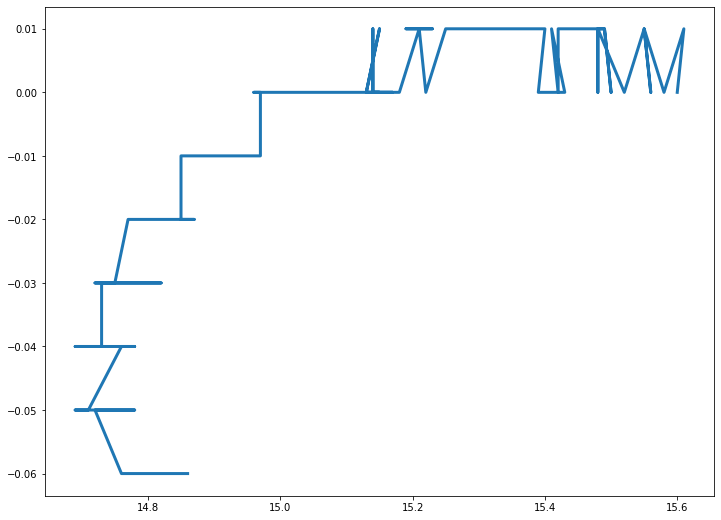

In [6]:
# Filtrado de datos.
plt.figure(figsize=(12, 9))
plt.plot(x[:250], y[:250], linewidth=3, label="y")

In [7]:
x = x[250:]
y = y[250:]

In [8]:
# Interpolación de los puntos del eje x.
x_interpolated = np.linspace(x.min(), x.max(), len(x))
y_interpolated = interp1d(x, y)(x_interpolated)

In [9]:
def calculate_derivative(x, y):
    dx = np.gradient(x)   # Calcular el espaciado entre puntos en el eje x
    dy = np.gradient(y)   # Calcular la diferencia entre puntos en el eje y
    derivative = dy / dx  # Calcular la derivada punto por punto
    return derivative
#(x_interpolated, y_smooth)
derivative_raw = calculate_derivative(x_interpolated, y_interpolated)
print(derivative_raw)

[-0.04441676 -0.02220838 -0.02220838 ...  0.          0.
  0.        ]


In [10]:
temp = np.where(x_interpolated>134)[0][0]
temp

530

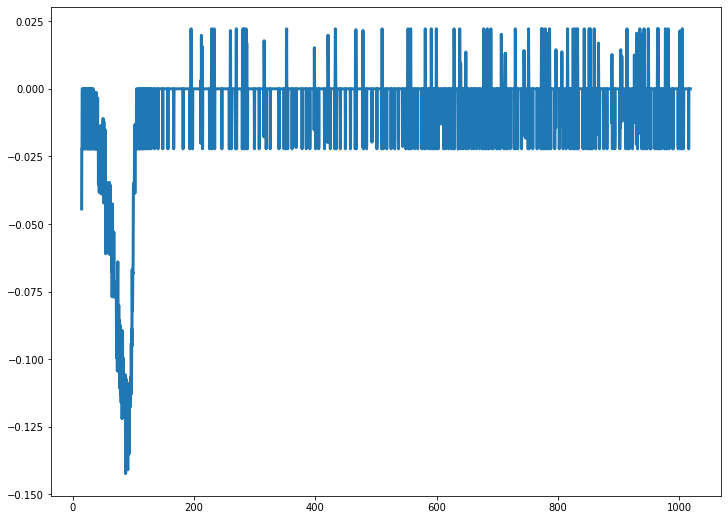

In [11]:
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated[:], derivative_raw[:], linewidth=3, label="y_dev_smooth")

In [12]:
end_start = np.where(x_interpolated > 134)[0][0]  # Filtrado de datos
print(end_start)

530


In [13]:
# Definir las regiones donde se aplicará el suavizado
transition_index = end_start

# Aplicar suavizado en cada región con diferentes parámetros
#y_smooth = apply_savgol_smoothing(y_interpolated, transition_index, window_length1=60, polyorder1=2, window_length2=100, polyorder2=2)

In [14]:
# y_smooth = ss.savgol_filter(y, window_length=100, polyorder=2)
y_smooth = gaussian_filter1d(y_interpolated, sigma=15, order=0)

In [15]:
#y_smooth = apply_mix_smoothing(y_interpolated, transition_index = (end_start-60), window_length1 = 100, polyorder1 = 2, sigma2= 10)

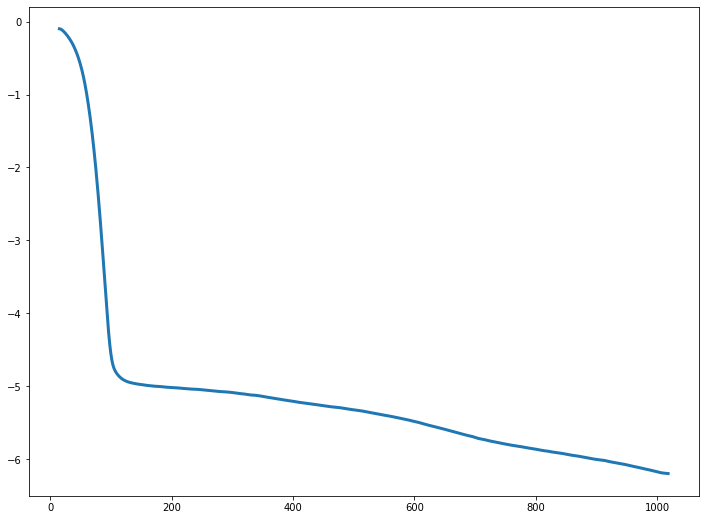

In [16]:
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated, y_smooth, linewidth=3, label="y_smoothed")

In [17]:
derivative = calculate_derivative(x_interpolated, y_smooth)
print(derivative)

[-4.09323390e-04 -6.12985133e-04 -1.01864973e-03 ... -2.35405471e-04
 -1.42038614e-04 -9.49551346e-05]


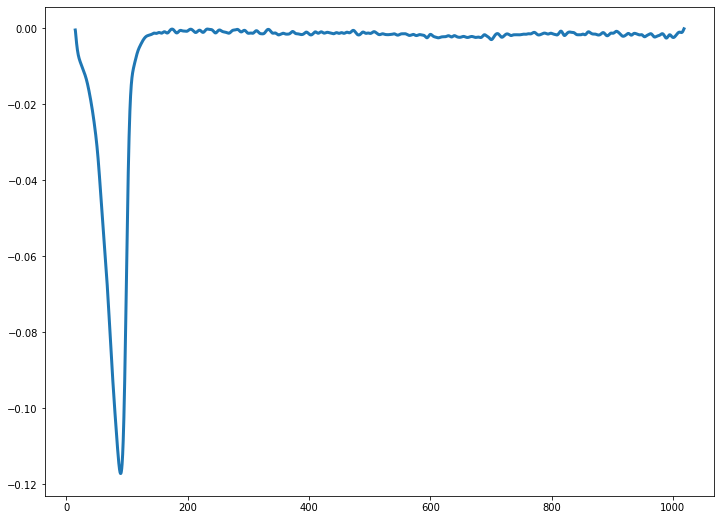

In [18]:
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated, derivative, linewidth=3, label="y_dev_smooth")

<Figure size 864x648 with 0 Axes>

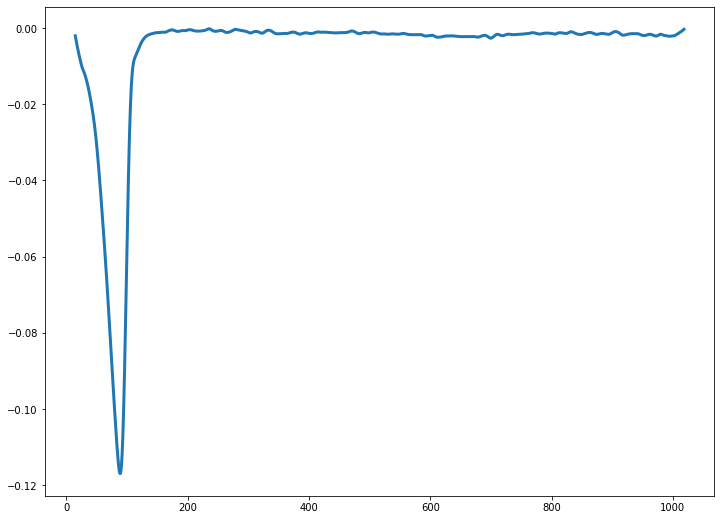

In [19]:
# Aplicación del filtro de suavizado con kernel gaussiano en la primera derivada.
y_dev_smooth = ss.savgol_filter(derivative,window_length=100,polyorder=2,deriv=0)
plt.figure(figsize=(12, 9))
# gaussian_filter1d(derivative, sigma=11, order=0)
#ss.savgol_filter(derivative,window_length=50,polyorder=2,deriv=0)
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated[:], y_dev_smooth[:], linewidth=3, label="y_dev_smooth")

In [20]:
a = np.where(y_dev_smooth < 0)[0][0]  # Filtrado de datos
print(a)

0


In [21]:
print(x_interpolated[a])
print(y_dev_smooth[a])

14.85
-0.0020313313780932533


In [22]:
# Exportación de datos DTG de Mica-2 pura.
df2 = pd.DataFrame({"Temperatura":x_interpolated,"TG_smooth":y_smooth,"TG_dev":y_dev_smooth})
df2.to_csv('./nuevaCarpeta/Mica2_TG_smooth.txt',sep='\t',index=False,decimal=',')

In [23]:
#x_interpolated[:], derivative[:]
df3 = pd.DataFrame({"Temperatura":x,"DTG_raw":derivative_raw[:],"DTG_processed":y_dev_smooth})
df3.to_csv('./nuevaCarpeta/ejemploMica.txt',sep='\t',index=False,decimal=',')

In [24]:
b = np.where(x_interpolated>114.0)[0][0] #filtrado de datos
b

441

In [25]:
print(x_interpolated[b])
print(y_dev_smooth[b])

114.1368409243886
-0.007375964731427414


In [26]:
min_temp = np.where(y_dev_smooth == min(y_dev_smooth[a:b]))
print(x_interpolated[min_temp])
print(y_dev_smooth[min_temp])

[88.92113529]
[-0.11698043]


In [27]:
# Integración numérica con la regla trapezoidal.
resultado_original = np.trapz(y_dev_smooth[a:b],x_interpolated[a:b])
resultado_original

-4.769527121250362

In [29]:
# Cálculo del error
a_e = np.where(x>(x_interpolated[a]-0.1))[0][0]
b_e = np.where(x>(x_interpolated[b]+0.5))[0][0]
resultado_desplazado = np.trapz(y_dev_smooth[a_e:b_e], x_interpolated[a_e:b_e])
print("resultado desplazado:", resultado_desplazado)
error_integral = np.abs(resultado_original - resultado_desplazado)
print("error_integral:", error_integral)

resultado desplazado: -4.832838173395284
error_integral: 0.06331105214492183
